HRV Time-Domain Metrics:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  969.132167  138.35349   58.661954  105.779172   48.173937  112.515063   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0   37.141412  122.515169  113.658467  113.673605  ...      120.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     1.217274        910.0       1049.0  54.724092  82.799462      101.0   

   HRV_MaxNN    HRV_HTI  HRV_TINN  
0     1425.0  10.150273       0.0  

[1 rows x 25 columns]

HRV Frequency-Domain Metrics:
    HRV_ULF   HRV_VLF    HRV_LF    HRV_HF   HRV_VHF    HRV_TP  HRV_LFHF  \
0  0.000667  0.008424  0.006423  0.005556  0.000869  0.021939  1.156055   

    HRV_LFn   HRV_HFn  HRV_LnHF  
0  0.292769  0.253248 -5.192895  

HRV Non-Linear Metrics:
     HRV_SD1     HRV_SD2  HRV_SD1SD2         HRV_S   HRV_CSI   HRV_CVI  \
0  80.379377  178.073395    0.451383  44966.962145  2.215411  5.359864   

   HRV_CS

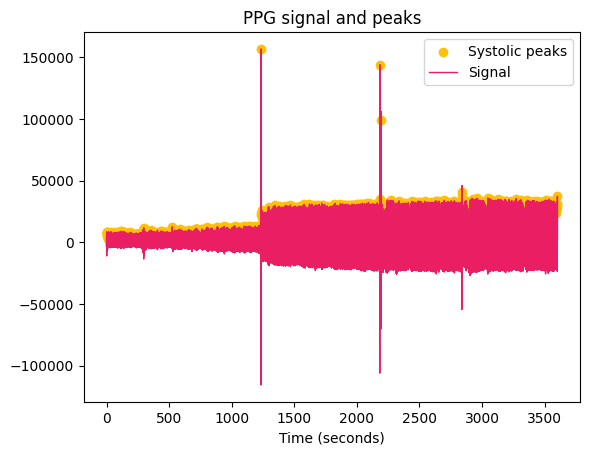

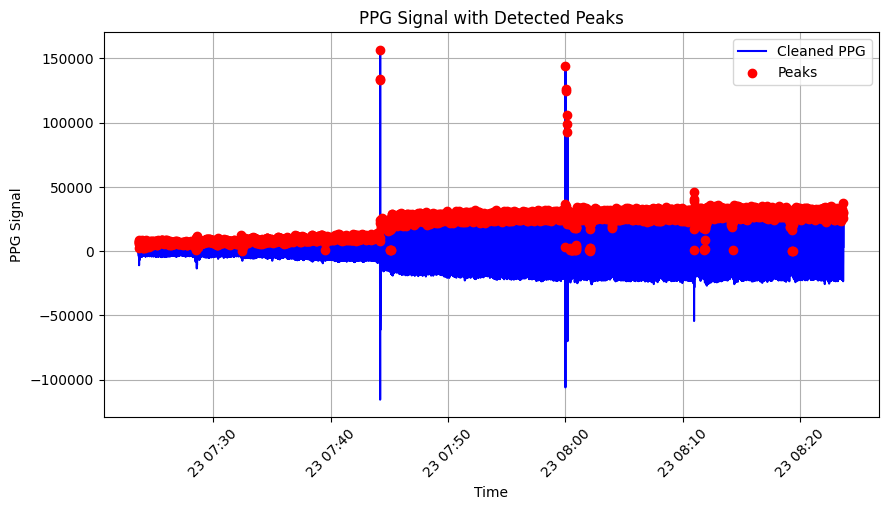

In [4]:
# 필요 라이브러리 임포트
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
import numpy as np
import json

# 기존 Firebase 앱이 있으면 삭제하고 새로 초기화
if firebase_admin._apps:
    firebase_admin.delete_app(firebase_admin.get_app())

# Firebase 앱 초기화 (사용자의 키와 URL로 수정 필요)
cred = credentials.Certificate("hrvdataset-firebase-adminsdk-oof96-2a96d6ac7f.json")  # Firebase Admin SDK JSON 파일
firebase_admin.initialize_app(cred, {"databaseURL": "https://hrvdataset-default-rtdb.firebaseio.com/"})

# 데이터 가져오기
# ref = db.reference("HeartRateData")
# data = ref.get()

# wakeup.json 파일에서 데이터 불러오기
with open("gosleep.json", "r") as f:
    data_json = json.load(f)


# 데이터 정리
ppg_values = []
timestamps = []

for key, value in data_json["HeartRateData"].items():
    if not value["isError"]:  # 오류 없는 데이터만 사용
        ppg_values.append(value["ppgGreen"])
        timestamps.append(pd.to_datetime(value["timestamp"]))

# 데이터프레임 생성 및 정렬
df = pd.DataFrame({"Timestamp": timestamps, "PPG": ppg_values})
df = df.sort_values("Timestamp")

# 초반 2초 데이터 삭제
start_time = df["Timestamp"].iloc[0]
df = df[df["Timestamp"] > start_time + pd.Timedelta(seconds=2)]

# PPG 신호 청소 (샘플링 주파수 25Hz)
fs = 25
ppg_cleaned = nk.ppg_clean(df["PPG"], sampling_rate=fs)

# 피크 검출 함수 (min_y 추가)
def find_prominent_peaks(signal, threshold=0.1, min_y=0):
    peaks = []
    for i in range(1, len(signal) - 1):
        if signal[i] > signal[i - 1] and signal[i] > signal[i + 1] and signal[i] > min_y:
            left_min = min(signal[max(0, i - 5):i])
            right_min = min(signal[i + 1:i + 6])
            prominence = signal[i] - max(left_min, right_min)
            if prominence > threshold:
                peaks.append(i)
    return peaks

# 피크 검출
min_y = 0
peaks_indices = find_prominent_peaks(ppg_cleaned, threshold=0.1, min_y=min_y)


# 피크의 타임스탬프와 값 추출
peaks_timestamps = df["Timestamp"].iloc[peaks_indices].values
peaks_values = ppg_cleaned[peaks_indices]

# RR 간격 계산 (밀리초 단위)
rr_intervals = np.diff(peaks_timestamps).astype('timedelta64[ms]').astype(int)

# RR 간격을 다시 피크 인덱스로 변환
peaks_from_rr = nk.intervals_to_peaks(rr_intervals)

# PPG 피크 검출
peaks, info = nk.ppg_peaks(ppg_cleaned, sampling_rate=fs, show=True)

# peaks 데이터프레임의 인덱스를 df와 일치시키기
peaks["Timestamp"] = df["Timestamp"].reset_index(drop=True)

# HRV 도메인별 분석
hrv_time_metrics = nk.hrv_time(peaks_from_rr, sampling_rate=1000)
hrv_frequency_metrics = nk.hrv_frequency(peaks_from_rr, sampling_rate=1000)
hrv_nonlinear_metrics = nk.hrv_nonlinear(peaks_from_rr, sampling_rate=1000)

# HRV 지표 출력
print("HRV Time-Domain Metrics:")
print(hrv_time_metrics)
print("\nHRV Frequency-Domain Metrics:")
print(hrv_frequency_metrics)
print("\nHRV Non-Linear Metrics:")
print(hrv_nonlinear_metrics)


# 시각화
plt.figure(figsize=(10, 5))
plt.plot(df["Timestamp"], ppg_cleaned, label="Cleaned PPG", color="blue")
plt.scatter(peaks_timestamps, peaks_values, color="red", label="Peaks", zorder=3)
plt.legend()
plt.xlabel("Time")
plt.ylabel("PPG Signal")
plt.title("PPG Signal with Detected Peaks")
plt.xticks(rotation=45)
plt.grid()
plt.show()


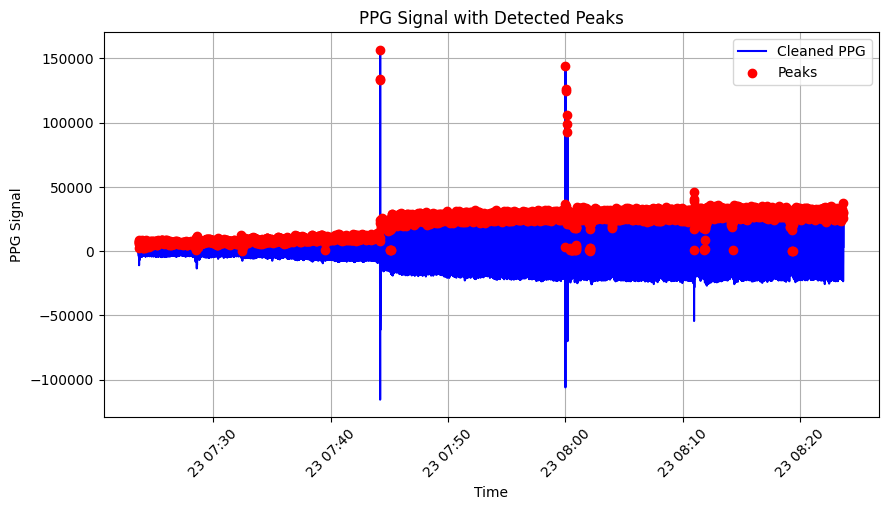

c:\Users\yeonn\Documents\Yeon\Project\Capstone\drowsiness-detection-using-hrv\.venv\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Users\yeonn\Documents\Yeon\Project\Capstone\drowsiness-detection-using-hrv\.venv\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Users\yeonn\Documents\Yeon\Project\Capstone\drowsiness-detection-using-hrv\.venv\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related in


===== Segment 08:21:50 → 08:23:50 =====
                  Time  Frequency  Nonlinear
csi                NaN        NaN      1.071
cvi                NaN        NaN      4.892
cvnni            0.069        NaN        NaN
cvsd             0.094        NaN        NaN
lf_hf_ratio        NaN      0.211        NaN
max_hr          72.727        NaN        NaN
mean_hr         59.878        NaN        NaN
mean_nni      1007.407        NaN        NaN
median_nni    1000.000        NaN        NaN
min_hr          50.505        NaN        NaN
modified_csi       NaN        NaN    309.355
nni_20          93.000        NaN        NaN
nni_50          69.000        NaN        NaN
pnni_20         87.037        NaN        NaN
pnni_50         56.481        NaN        NaN
power_hf           NaN   2706.517        NaN
power_lf           NaN    570.855        NaN
power_vlf          NaN        NaN        NaN
range_nni      360.000        NaN        NaN
rmssd           94.957        NaN        NaN
sampen        

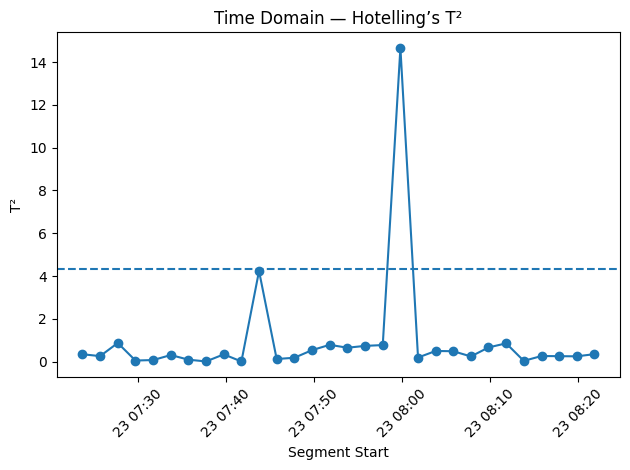

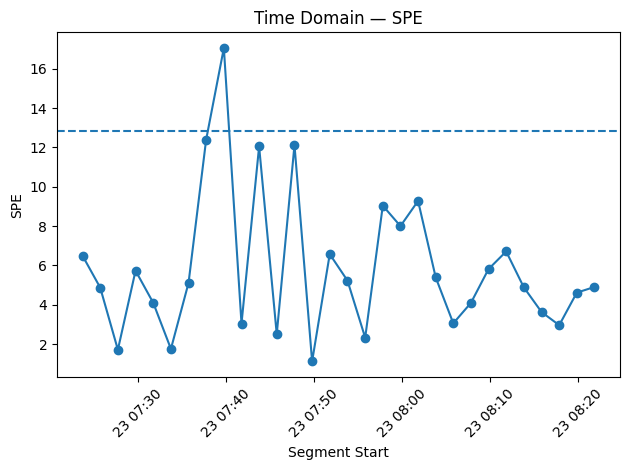


=== Time Domain Out‑of‑Control Segments ===
             Segment Start             Segment End  Time_OOC_T2  Time_OOC_SPE
8  2025-03-23 07:39:42.968 2025-03-23 07:41:42.968        False          True
18 2025-03-23 07:59:47.725 2025-03-23 08:01:47.725         True         False


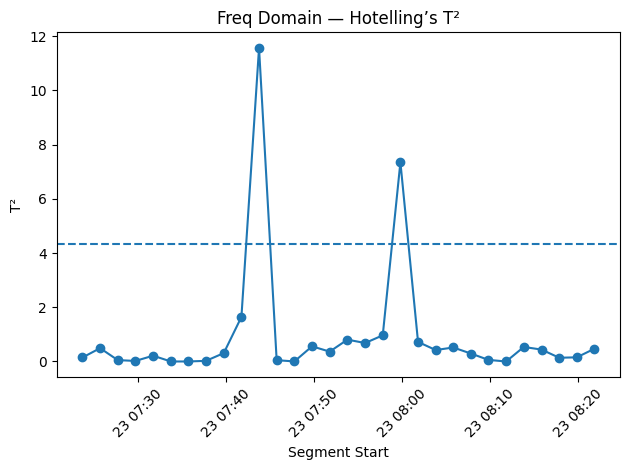

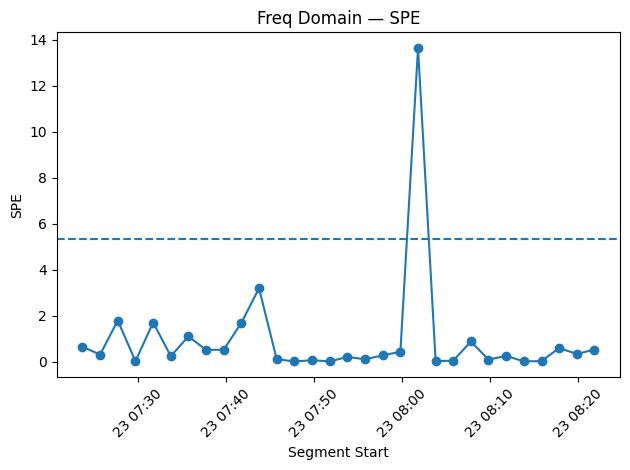


=== Freq Domain Out‑of‑Control Segments ===
             Segment Start             Segment End  Freq_OOC_T2  Freq_OOC_SPE
10 2025-03-23 07:43:43.471 2025-03-23 07:45:43.471         True         False
18 2025-03-23 07:59:47.725 2025-03-23 08:01:47.725         True         False
19 2025-03-23 08:01:47.937 2025-03-23 08:03:47.937        False          True


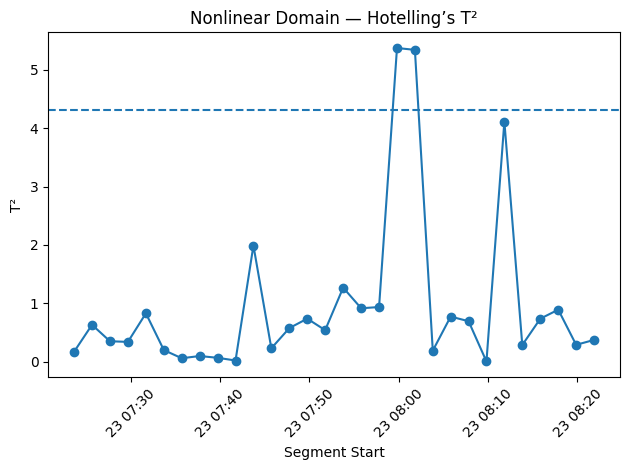

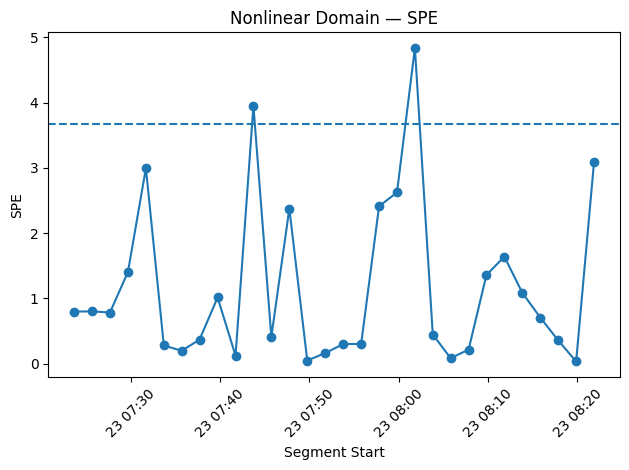


=== Nonlinear Domain Out‑of‑Control Segments ===
             Segment Start             Segment End  Nonlinear_OOC_T2  \
10 2025-03-23 07:43:43.471 2025-03-23 07:45:43.471             False   
18 2025-03-23 07:59:47.725 2025-03-23 08:01:47.725              True   
19 2025-03-23 08:01:47.937 2025-03-23 08:03:47.937              True   

    Nonlinear_OOC_SPE  
10               True  
18              False  
19               True  


In [5]:
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.stats import chi2, f
from sklearn.decomposition import PCA

# ---------------------------
# 기존 코드: 데이터 불러오기, 전처리, HRV 분석 및 CSV 저장
# ---------------------------

# 기존 Firebase 앱 초기화 (필요 시)
if firebase_admin._apps:
    firebase_admin.delete_app(firebase_admin.get_app())

# Firebase 앱 초기화 (사용자의 키와 URL로 수정 필요)
cred = credentials.Certificate("hrvdataset-firebase-adminsdk-oof96-2a96d6ac7f.json")
firebase_admin.initialize_app(cred, {"databaseURL": "https://hrvdataset-default-rtdb.firebaseio.com/"})

# 데이터 가져오기
# ref = db.reference("HeartRateData")
# data = ref.get()

# gosleep.json 파일에서 데이터 불러오기 (firebase와 동일한 형식)
with open("gosleep.json", "r") as file_in:
    data_json = json.load(file_in)

# 데이터 정리 (오류 없는 데이터만 사용)
ppg_values = []
timestamps = []
for key, value in data_json["HeartRateData"].items():
    if not value["isError"]:
        ppg_values.append(value["ppgGreen"])
        timestamps.append(pd.to_datetime(value["timestamp"]))

# 데이터프레임 생성 및 타임스탬프 기준 정렬
df = pd.DataFrame({"Timestamp": timestamps, "PPG": ppg_values})
df = df.sort_values("Timestamp")

# 초반 2초 데이터 삭제 (시작 안정화)
start_time = df["Timestamp"].iloc[0]
df = df[df["Timestamp"] > start_time + pd.Timedelta(seconds=2)]

# PPG 신호 청소 (샘플링 주파수 25Hz)
fs = 25
ppg_cleaned = nk.ppg_clean(df["PPG"], sampling_rate=fs)

# 피크 검출 함수 (min_y 추가)
def find_prominent_peaks(signal, threshold=0.1, min_y=0):
    peaks = []
    for i in range(1, len(signal) - 1):
        if signal[i] > signal[i - 1] and signal[i] > signal[i + 1] and signal[i] > min_y:
            left_min = min(signal[max(0, i - 5):i])
            right_min = min(signal[i + 1:i + 6])
            prominence = signal[i] - max(left_min, right_min)
            if prominence > threshold:
                peaks.append(i)
    return peaks

# 전체 신호에 대해 피크 검출
peaks_indices = find_prominent_peaks(ppg_cleaned, threshold=0.1, min_y=0)
peaks_timestamps = df["Timestamp"].iloc[peaks_indices].values  # numpy array of timestamps
peaks_values = ppg_cleaned[peaks_indices]

# 전체 신호 및 피크 시각화 (옵션)
plt.figure(figsize=(10, 5))
plt.plot(df["Timestamp"], ppg_cleaned, label="Cleaned PPG", color="blue")
plt.scatter(peaks_timestamps, peaks_values, color="red", label="Peaks", zorder=3)
plt.legend()
plt.xlabel("Time")
plt.ylabel("PPG Signal")
plt.title("PPG Signal with Detected Peaks")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# ----------------------------------------------------
# 피크 기준으로 2분 단위 HRV 분석
# ----------------------------------------------------
hrv_results = []
i = 0
while i < len(peaks_timestamps):
    seg_start = peaks_timestamps[i]
    seg_end = seg_start + pd.Timedelta(minutes=2)
    segment_peaks = []
    while i < len(peaks_timestamps) and peaks_timestamps[i] < seg_end:
        segment_peaks.append(peaks_indices[i])
        i += 1
    if len(segment_peaks) < 2:  
        print(f"구간 {seg_start} ~ {seg_end} 에는 피크가 부족하여 HRV 계산을 건너뜁니다.")
        continue
        
    # rr_intervals = np.diff(segment_peaks).astype("timedelta64[ms]").astype(int)
    # peaks_from_rr = nk.intervals_to_peaks(rr_intervals)
    

    
    # HR 시리즈 생성 (bpm)
    segment_times = peaks_timestamps[i-len(segment_peaks):i]  # datetime64 array
    rri = np.diff(segment_times).astype("timedelta64[ms]").astype(int)  # ms 단위 RR intervals
    hr_series = 60000 / rri
    
    hrv_time = nk.hrv_time(segment_peaks, sampling_rate=25)
    
    hrv_time_metrics = {
        "mean_nni": hrv_time["HRV_MeanNN"].iloc[0],
        "median_nni": hrv_time["HRV_MedianNN"].iloc[0],
        "range_nni": hrv_time["HRV_MaxNN"].iloc[0] - hrv_time["HRV_MinNN"].iloc[0],
        "sdnn": hrv_time["HRV_SDNN"].iloc[0],
        "sdsd": hrv_time["HRV_SDSD"].iloc[0],
        "rmssd": hrv_time["HRV_RMSSD"].iloc[0],
        "nni_50": int(np.sum(np.abs(np.diff(rri)) > 50)),
        "pnni_50": hrv_time["HRV_pNN50"].iloc[0],
        "nni_20": int(np.sum(np.abs(np.diff(rri)) > 20)),
        "pnni_20": hrv_time["HRV_pNN20"].iloc[0],
        "cvsd": hrv_time["HRV_CVSD"].iloc[0],
        "cvnni": hrv_time["HRV_CVNN"].iloc[0],
        "mean_hr": np.nanmean(hr_series),
        "min_hr": np.nanmin(hr_series),
        "max_hr": np.nanmax(hr_series),
        "std_hr": np.nanstd(hr_series, ddof=1),
    }
    
    hrv_freq = nk.hrv_frequency(segment_peaks, sampling_rate=25, normalize=False)
    
    if not hrv_freq.empty:
        hrv_freq_metrics = {
            "power_vlf": hrv_freq["HRV_VLF"].iloc[0],
            "power_lf":  hrv_freq["HRV_LF"].iloc[0],
            "power_hf":  hrv_freq["HRV_HF"].iloc[0],
            "total_power": hrv_freq["HRV_TP"].iloc[0],
            "lf_hf_ratio": hrv_freq["HRV_LFHF"].iloc[0]
        }
    else:
        hrv_freq_metrics = {k: np.nan for k in ["power_vlf","power_lf","power_hf","total_power","lf_hf_ratio"]}
    
    hrv_nonlinear = nk.hrv_nonlinear(segment_peaks, sampling_rate=25)
    if not hrv_nonlinear.empty:
        hrv_nonlinear_metrics = {
            "csi":            hrv_nonlinear["HRV_CSI"].iloc[0],
            "cvi":            hrv_nonlinear["HRV_CVI"].iloc[0],
            "modified_csi":   hrv_nonlinear["HRV_CSI_Modified"].iloc[0],
            "sampen":         hrv_nonlinear["HRV_SampEn"].iloc[0],
        }
    else:
        hrv_nonlinear_metrics = {k: np.nan for k in ["csi","cvi","modified_csi","sampen"]}
    
    
    result = {
        "Segment Start": seg_start,
        "Segment End": seg_end,
        "HRV Time Metrics": hrv_time_metrics,
        "HRV Frequency Metrics": hrv_freq_metrics,
        "HRV Nonlinear Metrics": hrv_nonlinear_metrics
    }
    hrv_results.append(result)

# HRV 결과를 하나의 DataFrame으로 결합하기
results_list = []
for res in hrv_results:
    row = {
        "Segment Start": res["Segment Start"],
        "Segment End":   res["Segment End"]
    }
    # Time-domain dict → Time_ 접두어
    for key, val in res["HRV Time Metrics"].items():
        row[f"Time_{key}"] = val

    # Frequency-domain dict → Freq_ 접두어
    for key, val in res["HRV Frequency Metrics"].items():
        row[f"Freq_{key}"] = val

    # Nonlinear-domain dict → Nonlinear_ 접두어
    for key, val in res["HRV Nonlinear Metrics"].items():
        row[f"Nonlinear_{key}"] = val

    results_list.append(row)

df_hrv_results = pd.DataFrame(results_list)

# --- 딕셔너리 → DataFrame 생성 ---
df_segment = pd.DataFrame({
    "Time": pd.Series(res["HRV Time Metrics"]),
    "Frequency": pd.Series(res["HRV Frequency Metrics"]),
    "Nonlinear": pd.Series(res["HRV Nonlinear Metrics"])
})


start_str = pd.to_datetime(seg_start).strftime("%H:%M:%S")
end_str   = pd.to_datetime(seg_end).strftime("%H:%M:%S")
# 출력
print(f"\n===== Segment {start_str} → {end_str} =====")
print(df_segment.round(3))


# HRV 결과 CSV 파일로 저장하려면 여기 사용용
df_hrv_results.to_csv("hrv_results.csv", index=False)
print("HRV 결과가 hrv_results.csv 파일에 저장되었습니다.")

# ---------------------------
# Anomaly Detection using PCA (각 도메인별)
# ---------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import chi2, f
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.05
N = len(df_hrv_results)

# 도메인별 컬럼 매핑
domains = {
    "Time": df_hrv_results.filter(regex="^Time_").columns,
    "Freq": df_hrv_results.filter(regex="^Freq_").columns,
    "Nonlinear": df_hrv_results.filter(regex="^Nonlinear_").columns
}

for domain, cols in domains.items():
    # 1) 데이터 준비 및 표준화
    X = df_hrv_results[cols].fillna(0).values.astype(float)
    X_scaled = StandardScaler().fit_transform(X)

    # 2) PCA (단일 주성분)
    pca = PCA(n_components=1)
    scores = pca.fit_transform(X_scaled).flatten()
    variance = pca.explained_variance_[0]

    # 3) Hotelling’s T² 계산
    T2 = (scores ** 2) / variance
    ulc_t2 = (1 * (N + 1) * (N - 1) / (N * (N - 1))) * f.ppf(1 - alpha, 1, N - 1)

    # 4) SPE (Q‑statistic) 계산
    X_hat = pca.inverse_transform(scores.reshape(-1, 1))
    SPE = ((X_scaled - X_hat) ** 2).sum(axis=1)
    b, v = SPE.mean(), SPE.var()
    df_chi = (2 * b * b) / v
    ulc_spe = (v / (2 * b)) * chi2.ppf(1 - alpha, df_chi)

    # 5) 결과 DataFrame 추가
    df_hrv_results[f"{domain}_T2"] = T2
    df_hrv_results[f"{domain}_SPE"] = SPE
    df_hrv_results[f"{domain}_OOC_T2"] = T2 > ulc_t2
    df_hrv_results[f"{domain}_OOC_SPE"] = SPE > ulc_spe

    # 6) Control Chart 시각화 — Hotelling’s T²
    plt.figure()
    plt.plot(df_hrv_results["Segment Start"], T2, marker="o")
    plt.axhline(ulc_t2, linestyle="--")
    plt.title(f"{domain} Domain — Hotelling’s T²")
    plt.xlabel("Segment Start")
    plt.ylabel("T²")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 7) Control Chart 시각화 — SPE
    plt.figure()
    plt.plot(df_hrv_results["Segment Start"], SPE, marker="o")
    plt.axhline(ulc_spe, linestyle="--")
    plt.title(f"{domain} Domain — SPE")
    plt.xlabel("Segment Start")
    plt.ylabel("SPE")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 8) 이상구간 출력
    ooc = df_hrv_results[df_hrv_results[f"{domain}_OOC_T2"] | df_hrv_results[f"{domain}_OOC_SPE"]]
    print(f"\n=== {domain} Domain Out‑of‑Control Segments ===")
    print(ooc[["Segment Start","Segment End",f"{domain}_OOC_T2",f"{domain}_OOC_SPE"]])



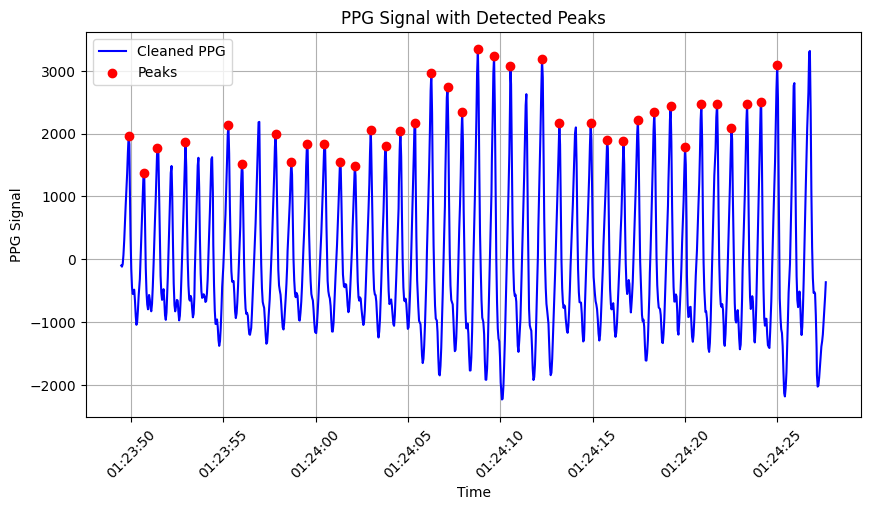

In [35]:
# neourokit2를 사용해 peak를 구하는 함수 peak는 정확하지만 탐지하지 못하는 peak가 있음
# 필요 라이브러리 임포트
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

if firebase_admin._apps:
    firebase_admin.delete_app(firebase_admin.get_app())

# 🔹 Firebase 앱 새로 초기화
cred = credentials.Certificate("hrvdataset-firebase-adminsdk-oof96-2a96d6ac7f.json")  # Firebase Admin SDK JSON 파일
firebase_admin.initialize_app(cred, {"databaseURL": "https://hrvdataset-default-rtdb.firebaseio.com/"})

ref = db.reference("HeartRateData")
data = ref.get()

# 데이터 정리
ppg_values = []
timestamps = []

for key, value in data.items():
    if not value["isError"]:  # 오류 없는 데이터만 사용
        ppg_values.append(value["ppgGreen"])
        timestamps.append(pd.to_datetime(value["timestamp"]))

# 데이터프레임 생성
df = pd.DataFrame({"Timestamp": timestamps, "PPG": ppg_values})
df = df.sort_values("Timestamp")  # 시간 순 정렬

# 초반 2초의 데이터를 삭제
start_time = df["Timestamp"].iloc[0]
df = df[df["Timestamp"] > start_time + pd.Timedelta(seconds=2)]

# PPG 신호 처리 (25Hz 가정)
fs = 25  # 샘플링 주파수
ppg_cleaned = nk.ppg_clean(df["PPG"], sampling_rate=fs)

# PPG 피크 검출
peaks, info = nk.ppg_peaks(ppg_cleaned, sampling_rate=fs)

# peaks 데이터프레임의 인덱스를 df와 일치시키기
peaks["Timestamp"] = df["Timestamp"].reset_index(drop=True)

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(df["Timestamp"], ppg_cleaned, label="Cleaned PPG", color="blue")
plt.scatter(peaks["Timestamp"][peaks["PPG_Peaks"] == 1], ppg_cleaned[peaks["PPG_Peaks"] == 1], color="red", label="Peaks", zorder=3)
plt.legend()
plt.xlabel("Time")
plt.ylabel("PPG Signal")
plt.title("PPG Signal with Detected Peaks")
plt.xticks(rotation=45)
plt.grid()
plt.show()
